In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import fsolve, minimize_scalar
from scipy.interpolate import interp1d

============================================================================
AIRCRAFT CONFIGURATION and FILE DIRECTORY
============================================================================

In [37]:
RHO = 1.225  # Air density at sea level [kg/m^3]

THROTTLE_PERCENT = 70  # Throttle percentage for cruise analysis
VOLTAGE = 21.6  # Battery voltage (6s = 21.6V)
KV = 580  # Motor Kv rating
SELECTED_RPMS = [5000, 8000, 11000, 14000, 17000]  # RPMs to plot
n = 2  # Number of motors
W = 3.94 * 9.81  # Aircraft weight [N]
S = 0.56  # Wing area [m^2]

V_CRUISE = 22.2  # Cruise speed [m/s], from QAPOT
CLIMB_ALT = 61  # Circuit altitude [m], 200ft = 61m, team choice, AGL

# Wing geometry for 3D correction
AR = 4.0  # Aspect ratio - OML1 value
WING_INCIDENCE = 1.0  # Wing incidence angle [degrees] (positive is up)

# File paths
SCRIPT_DIR = Path.cwd()

DATA_FILE = SCRIPT_DIR / "PER3_10x6E.dat"
AIRFOIL_CL_FILE = SCRIPT_DIR / "N10CLalpha.txt"
AIRFOIL_CD_FILE = SCRIPT_DIR / "N10CdAlpha.txt"
AIRCRAFT_FILE = SCRIPT_DIR / "OML1T2394kg.csv"

============================================================================
AIRFOIL DATA FUNCTIONS - FROM TEXT FILES
============================================================================

In [38]:
def load_airfoil_from_txt(cl_file, cd_file, AR, wing_incidence=0.0):
    """
    Load airfoil data from separate CL and CD text files and apply 3D corrections
    
    Parameters:
    -----------
    cl_file : Path
        Path to CL vs alpha file
    cd_file : Path
        Path to CD vs alpha file
    AR : float
        Aspect ratio for 3D correction
    wing_incidence : float
        Wing incidence angle in degrees (default 0.0)
    
    Returns:
    --------
    airfoil_data : DataFrame
        Contains 2D and 3D corrected data
    stall_data : dict
        Stall characteristics using 3D corrected values
    """
    print(f"Loading airfoil CL data from {cl_file}")
    print(f"Loading airfoil CD data from {cd_file}")
    
    # Read CL file (2D data)
    cl_data = pd.read_csv(cl_file, delim_whitespace=True, header=None, 
                         names=['alpha', 'Cl_2d'], skiprows=1)
    
    # Read CD file (2D data)
    cd_data = pd.read_csv(cd_file, delim_whitespace=True, header=None,
                         names=['alpha', 'Cd_2d'], skiprows=1)
    
    # Clean up the data
    cl_data['alpha'] = cl_data['alpha'].astype(float)
    cl_data['Cl_2d'] = cl_data['Cl_2d'].astype(float)
    cd_data['alpha'] = cd_data['alpha'].astype(float)
    cd_data['Cd_2d'] = cd_data['Cd_2d'].astype(float)
    
    # Merge CL and CD data
    airfoil_data = pd.merge(cl_data, cd_data, on='alpha', how='inner')
    
    print(f"\nLoaded {len(airfoil_data)} airfoil data points")
    print(f"Alpha range: {airfoil_data['alpha'].min():.1f}° to {airfoil_data['alpha'].max():.1f}°")
    
    # ========================================================================
    # APPLY 3D CORRECTION
    # ========================================================================
    
    # Calculate 2D lift slope (Cla) in per degree from linear region
    # Find linear region (typically -5 to +5 degrees)
    linear_mask = (airfoil_data['alpha'] >= -5) & (airfoil_data['alpha'] <= 5)
    linear_data = airfoil_data[linear_mask]
    
    # Linear regression to get Cla in per degree
    coeffs = np.polyfit(linear_data['alpha'], linear_data['Cl_2d'], 1)
    Cla_per_deg = coeffs[0]
    
    # Convert to per radian
    Cla_per_rad = Cla_per_deg * 180 / np.pi
    
    print(f"\n2D Lift Slope (Cla):")
    print(f"  Per degree: {Cla_per_deg:.6f} /deg")
    print(f"  Per radian: {Cla_per_rad:.4f} /rad")
    
    # Apply 3D correction: CLa = Cla / (1 + Cla / (π * e * AR))
    # Using e = 1.0 as specified (since e is baked into XFLR5 data)
    e = 1.0
    CLa_per_rad = Cla_per_rad / (1 + Cla_per_rad / (np.pi * e * AR))
    CLa_per_deg = CLa_per_rad * np.pi / 180
    
    print(f"\n3D Lift Slope (CLa) with AR={AR}, e={e}:")
    print(f"  Per degree: {CLa_per_deg:.6f} /deg")
    print(f"  Per radian: {CLa_per_rad:.4f} /rad")
    
    # Calculate 3D CL for each alpha
    # Find alpha_L0 (zero-lift angle) from 2D data
    alpha_L0 = -coeffs[1] / coeffs[0]  # From Cl = Cla * (alpha - alpha_L0)
    
    # Apply 3D correction to entire curve
    airfoil_data['CL_3d'] = CLa_per_deg * (airfoil_data['alpha'] - alpha_L0)
    
    # For CD, keep 2D values (drag correction is handled by XFLR5)
    airfoil_data['CD'] = airfoil_data['Cd_2d']
    
    # ========================================================================
    # FIND STALL POINT USING 3D CORRECTED DATA
    # ========================================================================
    
    # Find stall from 3D corrected CL
    max_cl_idx = airfoil_data['CL_3d'].idxmax()
    
    # Stall angle at section level
    alpha_stall_section = airfoil_data.loc[max_cl_idx, 'alpha']
    
    # Convert to body-axis stall angle
    # α_body,stall = α_stall,section - i_w
    alpha_stall_body = alpha_stall_section - wing_incidence
    
    stall_data = {
        'alpha_stall_section': alpha_stall_section,  # Section stall angle
        'alpha_stall_body': alpha_stall_body,        # Body-axis stall angle
        'CL_max_3d': airfoil_data.loc[max_cl_idx, 'CL_3d'],
        'Cl_max_2d': airfoil_data.loc[max_cl_idx, 'Cl_2d'],
        'Cd_at_stall': airfoil_data.loc[max_cl_idx, 'CD'],
        'wing_incidence': wing_incidence,
        'AR': AR,
        'Cla_2d_per_rad': Cla_per_rad,
        'CLa_3d_per_rad': CLa_per_rad
    }
    
    print("\n" + "="*70)
    print("AIRFOIL STALL CHARACTERISTICS (3D CORRECTED)")
    print("="*70)
    print(f"Wing Incidence (i_w):          {wing_incidence:.2f}°")
    print(f"Aspect Ratio (AR):             {AR:.2f}")
    print(f"\nStall Angle (section):         {stall_data['alpha_stall_section']:.2f}°")
    print(f"Stall Angle (body-axis):       {stall_data['alpha_stall_body']:.2f}°")
    print(f"\nMaximum CL (3D):               {stall_data['CL_max_3d']:.4f}")
    print(f"Maximum Cl (2D):               {stall_data['Cl_max_2d']:.4f}")
    print(f"Cd at stall:                   {stall_data['Cd_at_stall']:.5f}")
    print(f"\n2D Lift Slope (Cla):           {Cla_per_rad:.4f} /rad")
    print(f"3D Lift Slope (CLa):           {CLa_per_rad:.4f} /rad")
    print(f"Reduction factor:              {CLa_per_rad/Cla_per_rad:.4f}")
    print("="*70)
    
    return airfoil_data, stall_data


def get_airfoil_value(airfoil_data, alpha_target, column='CL_3d'):
    """
    Interpolate airfoil data at a given angle of attack
    
    Parameters:
    -----------
    airfoil_data : DataFrame
        Airfoil data
    alpha_target : float
        Target angle of attack in degrees
    column : str
        Column to interpolate ('CL_3d', 'Cl_2d', 'CD', etc.)
    """
    f = interp1d(airfoil_data['alpha'], airfoil_data[column], 
                 kind='linear', fill_value='extrapolate')
    return float(f(alpha_target))


def get_alpha_from_cl(airfoil_data, cl_target, use_3d=True):
    """
    Get angle of attack for a given CL (inverse lookup)
    
    Parameters:
    -----------
    airfoil_data : DataFrame
        Airfoil data
    cl_target : float
        Target lift coefficient
    use_3d : bool
        If True, use 3D corrected CL, else use 2D Cl
    """
    column = 'CL_3d' if use_3d else 'Cl_2d'
    f = interp1d(airfoil_data[column], airfoil_data['alpha'], 
                 kind='linear', fill_value='extrapolate')
    return float(f(cl_target))

============================================================================
AIRCRAFT DATA FUNCTIONS
============================================================================

In [39]:
def load_aircraft_data(aircraft_file):
    """Load aircraft performance data from Flow5/XFLR5 output"""
    print(f"\nLoading aircraft data from {aircraft_file}")
    
    # Read the file manually to understand structure
    with open(aircraft_file, 'r') as f:
        lines = f.readlines()
    
    # Find where data starts (skip header lines)
    data_start = 0
    for i, line in enumerate(lines):
        # Look for line that starts with numbers (data)
        stripped = line.strip()
        if stripped and stripped[0].isdigit() or (stripped and stripped[0] == '-' and stripped[1].isdigit()):
            data_start = i
            break
    
    print(f"Data starts at line {data_start}")
    
    # Get header from line before data
    if data_start > 3:
        header_line = lines[3].strip()  # Usually line 3 is header
        print(f"Header line: {header_line}")
        
        # Read data starting from data_start
        data = pd.read_csv(aircraft_file, skiprows=3)
    else:
        # Fallback: try reading with skiprows=3
        data = pd.read_csv(aircraft_file, skiprows=3)
    
    # Clean column names
    data.columns = [col.strip() for col in data.columns]
    print(f"\nLoaded {len(data)} rows")
    print(f"Columns: {list(data.columns)}")
    
    # Find key columns
    v_col = None
    cl_col = None
    cd_col = None
    alpha_col = None
    cd_viscous_col = None
    cd_induced_col = None
    l_d_col = None
    
    for col in data.columns:
        col_lower = col.lower()
        if 'v (' in col_lower and 'm/s' in col_lower:
            v_col = col
        elif col == 'CL':
            cl_col = col
        elif col == 'CD':
            cd_col = col
        elif 'α' in col or 'alpha' in col_lower:
            alpha_col = col
        elif 'cd_viscous' in col_lower:
            cd_viscous_col = col
        elif 'cd_induced' in col_lower:
            cd_induced_col = col
        elif 'cl/cd' in col_lower:
            l_d_col = col
    
    # If still not found, check by position
    if not v_col:
        for col in data.columns:
            if 'v' in col_lower:
                v_col = col
                break
    
    # Use positions as last resort
    if not cl_col and len(data.columns) > 4:
        cl_col = data.columns[4]  # CL is usually 5th column
    if not cd_col and len(data.columns) > 5:
        cd_col = data.columns[5]  # CD is usually 6th column
    if not v_col and len(data.columns) > 29:
        v_col = data.columns[29]  # V (m/s) is often around column 30
    
    print(f"\nKey columns identified:")
    print(f"  Velocity: {v_col}")
    print(f"  CL: {cl_col}")
    print(f"  CD: {cd_col}")
    print(f"  Alpha: {alpha_col}")
    print(f"  CD_viscous: {cd_viscous_col}")
    print(f"  CD_induced: {cd_induced_col}")
    print(f"  L/D: {l_d_col}")
    
    if not v_col or not cl_col or not cd_col:
        print("WARNING: Could not find all essential columns")
        print("First 3 rows of data:")
        print(data.head(3).to_string())
        
        # Create dummy data for testing
        if not v_col:
            v_col = 'V'
            data[v_col] = np.linspace(10, 30, len(data))
        if not cl_col:
            cl_col = 'CL'
            data[cl_col] = np.linspace(0.2, 1.2, len(data))
        if not cd_col:
            cd_col = 'CD'
            data[cd_col] = np.linspace(0.02, 0.08, len(data))
    
    # Create interpolation functions
    interp_funcs = {}
    if v_col and cl_col:
        interp_funcs['CL'] = interp1d(data[v_col], data[cl_col], kind='linear', fill_value='extrapolate')
    if v_col and cd_col:
        interp_funcs['CD'] = interp1d(data[v_col], data[cd_col], kind='linear', fill_value='extrapolate')
    if v_col and alpha_col:
        interp_funcs['Alpha'] = interp1d(data[v_col], data[alpha_col], kind='linear', fill_value='extrapolate')
    if v_col and cd_viscous_col:
        interp_funcs['CD_viscous'] = interp1d(data[v_col], data[cd_viscous_col], kind='linear', fill_value='extrapolate')
    if v_col and cd_induced_col:
        interp_funcs['CD_induced'] = interp1d(data[v_col], data[cd_induced_col], kind='linear', fill_value='extrapolate')
    if v_col and l_d_col:
        interp_funcs['L/D'] = interp1d(data[v_col], data[l_d_col], kind='linear', fill_value='extrapolate')
    
    print("\n" + "="*70)
    print("AIRCRAFT DATA LOADED")
    print("="*70)
    print(f"Velocity range:  {data[v_col].min():.2f} - {data[v_col].max():.2f} m/s")
    print(f"CL range:        {data[cl_col].min():.4f} - {data[cl_col].max():.4f}")
    print(f"CD range:        {data[cd_col].min():.5f} - {data[cd_col].max():.5f}")
    if l_d_col:
        print(f"Max L/D:         {data[l_d_col].max():.2f} at V = {data.loc[data[l_d_col].idxmax(), v_col]:.2f} m/s")
    print("="*70)
    
    # Store column names
    data._v_col = v_col
    data._cl_col = cl_col
    data._cd_col = cd_col
    data._alpha_col = alpha_col
    data._cd_viscous_col = cd_viscous_col
    data._cd_induced_col = cd_induced_col
    data._l_d_col = l_d_col
    
    return data, interp_funcs

============================================================================
AERODYNAMIC FUNCTIONS
============================================================================

In [40]:
def V_STALL_func(w, S, CL_max):
    """
    Stall speed calculation using 3D corrected CL_max
    
    Parameters:
    -----------
    w : float
        Weight [N]
    S : float
        Wing area [m^2]
    CL_max : float
        Maximum 3D lift coefficient
    """
    return np.sqrt(2 * w / (RHO * S * CL_max))


def CL_function_data(velocity, interp_funcs):
    """Get CL from aircraft data"""
    if 'CL' in interp_funcs:
        return float(interp_funcs['CL'](velocity))
    else:
        print("WARNING: CL interpolation function not available")
        return 0.3
    

def CD_function_data(velocity, interp_funcs):
    """Get CD from aircraft data"""
    if 'CD' in interp_funcs:
        return float(interp_funcs['CD'](velocity))
    else:
        print("WARNING: CD interpolation function not available")
        return 0.03
    

def drag_total_force_data(velocity, interp_funcs):
    """Total drag force from aircraft data"""
    CD = CD_function_data(velocity, interp_funcs)
    return 0.5 * RHO * velocity**2 * S * CD


def drag_parasitic_force_data(velocity, interp_funcs):
    """Parasitic drag force from aircraft data"""
    if 'CD_viscous' in interp_funcs:
        CD_viscous = float(interp_funcs['CD_viscous'](velocity))
        return 0.5 * RHO * velocity**2 * S * CD_viscous
    else:
        return drag_total_force_data(velocity, interp_funcs) * 0.7
    

def drag_induced_force_data(velocity, interp_funcs):
    """Induced drag force from aircraft data"""
    if 'CD_induced' in interp_funcs:
        CD_induced = float(interp_funcs['CD_induced'](velocity))
        return 0.5 * RHO * velocity**2 * S * CD_induced
    else:
        return drag_total_force_data(velocity, interp_funcs) * 0.3
    

def get_alpha_data(velocity, interp_funcs):
    """Get angle of attack from aircraft data"""
    if 'Alpha' in interp_funcs:
        return float(interp_funcs['Alpha'](velocity))
    else:
        return 2.0

============================================================================
PROPELLER DATA FUNCTIONS
============================================================================

In [41]:
def parse_prop_data(file_path):
    """Parse propeller data from APC format .dat file"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    data = {}
    current_rpm = None
    i = 0
    
    while i < len(lines):
        line = lines[i]
        
        if "PROP RPM" in line:
            try:
                current_rpm = int(float(line.split("=")[1].strip()))
            except:
                i += 1
                continue
            
            data[current_rpm] = []
            i += 3
            continue
        
        if current_rpm and line.strip():
            parts = line.split()
            if len(parts) >= 12:
                try:
                    v_mph = float(parts[0])
                    v_ms = v_mph * 0.44704
                    thrust_lbf = float(parts[7])
                    thrust_N = n * thrust_lbf * 4.44822
                    power_W = float(parts[8])
                    
                    data[current_rpm].append({
                        'velocity_ms': v_ms,
                        'thrust_N': thrust_N,
                        'power_W': power_W
                    })
                except (ValueError, IndexError):
                    pass
        i += 1
    
    return data

def interpolate_rpm_data(prop_data, target_rpm):
    """Interpolate thrust and power data for a specific RPM"""
    available_rpms = sorted(prop_data.keys())
    
    if target_rpm in available_rpms:
        return prop_data[target_rpm]
    
    lower_rpm = max([rpm for rpm in available_rpms if rpm < target_rpm], default=None)
    upper_rpm = min([rpm for rpm in available_rpms if rpm > target_rpm], default=None)
    
    if lower_rpm is None or upper_rpm is None:
        nearest_rpm = min(available_rpms, key=lambda x: abs(x - target_rpm))
        return prop_data[nearest_rpm]
    
    lower_data = prop_data[lower_rpm]
    upper_data = prop_data[upper_rpm]
    alpha = (target_rpm - lower_rpm) / (upper_rpm - lower_rpm)
    
    interpolated = []
    for ld in lower_data:
        closest_ud = min(upper_data, key=lambda x: abs(x['velocity_ms'] - ld['velocity_ms']))
        
        if abs(closest_ud['velocity_ms'] - ld['velocity_ms']) < 1.0:
            interpolated.append({
                'velocity_ms': ld['velocity_ms'],
                'thrust_N': ld['thrust_N'] * (1 - alpha) + closest_ud['thrust_N'] * alpha,
                'power_W': ld['power_W'] * (1 - alpha) + closest_ud['power_W'] * alpha
            })
    
    return interpolated

def calculate_throttle_rpm(voltage, kv, throttle_percent):
    """Calculate RPM at given throttle setting"""
    return int(voltage * kv * (throttle_percent / 100))

def interpolate_thrust(throttle_data, velocity):
    """Interpolate thrust at a specific velocity"""
    velocities = np.array([d['velocity_ms'] for d in throttle_data])
    thrusts = np.array([d['thrust_N'] for d in throttle_data])
    return np.interp(velocity, velocities, thrusts)

def find_vmax(throttle_data, interp_funcs):
    """Find maximum velocity where thrust equals drag"""
    def thrust_minus_drag(v):
        thrust = interpolate_thrust(throttle_data, v)
        drag = drag_total_force_data(v, interp_funcs)
        return thrust - drag
    
    try:
        v_max = fsolve(thrust_minus_drag, 25.0)[0]
        return max(5.0, min(v_max, 50.0))
    except:
        print("WARNING: Could not solve for V_max, using default 25 m/s")
        return 25.0

============================================================================
POWER AND CLIMB PERFORMANCE FUNCTIONS
============================================================================

In [42]:
def power_available(velocity, thrust_data):
    """Power available: P_A = Thrust * Velocity"""
    thrust = interpolate_thrust(thrust_data, velocity)
    return thrust * velocity

def power_required_data(velocity, interp_funcs):
    """Power required: P_R = Drag * Velocity"""
    return drag_total_force_data(velocity, interp_funcs) * velocity

def find_max_excess_power(thrust_data, interp_funcs, v_min, v_max):
    """Find velocity where (P_A - P_R) is maximum"""
    def negative_excess_power(v):
        return -(power_available(v, thrust_data) - power_required_data(v, interp_funcs))
    
    try:
        result = minimize_scalar(negative_excess_power, bounds=(v_min, v_max), method='bounded')
        return result.x, -result.fun
    except:
        print("WARNING: Could not find max excess power")
        return (v_min + v_max) / 2, 100.0
    
def calculate_RC(velocity, thrust_data, interp_funcs):
    """Calculate rate of climb at a given velocity"""
    P_A = power_available(velocity, thrust_data)
    P_R = power_required_data(velocity, interp_funcs)
    excess_power = P_A - P_R
    return excess_power / W

============================================================================
OPTIMAL PERFORMANCE CALCULATIONS
============================================================================

In [43]:
def find_max_cl3_cd2(aircraft_data):
    """Find velocity that maximizes Cl^3/Cd^2 from actual data"""
    v_col = aircraft_data._v_col
    alpha_col = aircraft_data._alpha_col if hasattr(aircraft_data, '_alpha_col') else None
    cl_col = aircraft_data._cl_col
    cd_col = aircraft_data._cd_col
    
    # Calculate Cl^3/Cd^2 for each data point
    aircraft_data['Cl3_Cd2'] = aircraft_data[cl_col]**3 / aircraft_data[cd_col]**2
    
    # Find maximum
    max_idx = aircraft_data['Cl3_Cd2'].idxmax()
    
    result = {
        'velocity': aircraft_data.loc[max_idx, v_col],
        'CL': aircraft_data.loc[max_idx, cl_col],
        'CD': aircraft_data.loc[max_idx, cd_col],
        'Cl3_Cd2': aircraft_data.loc[max_idx, 'Cl3_Cd2']
    }
    
    if alpha_col:
        result['alpha'] = aircraft_data.loc[max_idx, alpha_col]
    else:
        result['alpha'] = 0
    
    return result

def calculate_glide_performance(aircraft_data):
    """Calculate optimal glide performance from data (max L/D)"""
    v_col = aircraft_data._v_col
    alpha_col = aircraft_data._alpha_col if hasattr(aircraft_data, '_alpha_col') else None
    cl_col = aircraft_data._cl_col
    cd_col = aircraft_data._cd_col
    
    # Calculate L/D for each point
    aircraft_data['L_D'] = aircraft_data[cl_col] / aircraft_data[cd_col]
    
    max_ld_idx = aircraft_data['L_D'].idxmax()
    
    V_glide = aircraft_data.loc[max_ld_idx, v_col]
    CL_glide = aircraft_data.loc[max_ld_idx, cl_col]
    CD_glide = aircraft_data.loc[max_ld_idx, cd_col]
    alpha_glide = aircraft_data.loc[max_ld_idx, alpha_col] if alpha_col else 0
    
    # Calculate glide angle and rate of descent
    gamma_glide = np.arctan(CD_glide / CL_glide)
    RD_glide = V_glide * np.sin(gamma_glide)
    
    return V_glide, gamma_glide, RD_glide, CL_glide, CD_glide, alpha_glide

def calculate_climb_time(RC, altitude):
    """Calculate time to climb to a certain altitude"""
    return altitude / RC

============================================================================
MAIN EXECUTION
============================================================================

In [44]:
# Load data files
print("="*70)
print("DATA-DRIVEN AERODYNAMIC ANALYSIS")
print("="*70)
print(f"\n1. Loading airfoil data from text files...")
airfoil_data, stall_data = load_airfoil_from_txt(AIRFOIL_CL_FILE, AIRFOIL_CD_FILE, AR, WING_INCIDENCE)
print(f"\n2. Loading aircraft data from {AIRCRAFT_FILE}...")
aircraft_data, interp_funcs = load_aircraft_data(AIRCRAFT_FILE)

# Get column names
v_col = aircraft_data._v_col
cl_col = aircraft_data._cl_col
cd_col = aircraft_data._cd_col
print(f"\n3. Loading propeller data from {DATA_FILE}...")
prop_data = parse_prop_data(DATA_FILE)
print(f"Loaded data for RPMs: {sorted(prop_data.keys())}")

# Calculate stall speed from airfoil max Cl
V_STALL = V_STALL_func(W, S, stall_data['CL_max_3d'])
print(f"\n4. Calculated stall speed: {V_STALL:.2f} m/s")

# Calculate throttle settings
throttle_rpm = calculate_throttle_rpm(VOLTAGE, KV, THROTTLE_PERCENT)
throttle_data = interpolate_rpm_data(prop_data, throttle_rpm)
throttle_rpm_100 = calculate_throttle_rpm(VOLTAGE, KV, 100)
throttle_data_100 = interpolate_rpm_data(prop_data, throttle_rpm_100)
V_MAX = find_vmax(throttle_data, interp_funcs)
print(f"5. Calculated maximum speed at {THROTTLE_PERCENT}% throttle: {V_MAX:.2f} m/s")
print("\n" + "="*70)

print("CLIMB PERFORMANCE CALCULATIONS (100% Throttle)")
print("="*70)
# 1. Maximum excess power (P_A - P_R)
throttle_velocities_100 = [d['velocity_ms'] for d in throttle_data_100]
v_min = max(V_STALL, min(throttle_velocities_100))
v_max = min(max(throttle_velocities_100) * 0.9, 40.0)
v_Pa_Pr_max, max_excess_power = find_max_excess_power(
    throttle_data_100, interp_funcs, v_min, v_max
)
RC_Pa_Pr_max = max_excess_power / W
Cl_Pa_Pr = CL_function_data(v_Pa_Pr_max, interp_funcs)
AoA_Pa_Pr = get_alpha_data(v_Pa_Pr_max, interp_funcs)
# 2. Climb at 1.2 * V_STALL
V_1_2_stall = 1.2 * V_STALL
RC_1_2_stall = calculate_RC(V_1_2_stall, throttle_data_100, interp_funcs)
Cl_1_2_stall = CL_function_data(V_1_2_stall, interp_funcs)
AoA_1_2_stall = get_alpha_data(V_1_2_stall, interp_funcs)
# 3. Best angle of climb (max Cl^3/Cd^2) - from data
max_performance = find_max_cl3_cd2(aircraft_data)
V_max_performance = max_performance['velocity']
RC_max_performance = calculate_RC(V_max_performance, throttle_data_100, interp_funcs)
Cl_max_performance = max_performance['CL']
Cd_max_performance = max_performance['CD']
AoA_max_performance = max_performance['alpha']
# 4. Glide performance - from data
V_glide, gamma_glide, RD_glide, Cl_glide, Cd_glide, AoA_glide = calculate_glide_performance(aircraft_data)

DATA-DRIVEN AERODYNAMIC ANALYSIS

1. Loading airfoil data from text files...
Loading airfoil CL data from c:\Users\liuja\Trial1OfVspQAPOT\Aero-Basic-Performance\N10CLalpha.txt
Loading airfoil CD data from c:\Users\liuja\Trial1OfVspQAPOT\Aero-Basic-Performance\N10CdAlpha.txt

Loaded 84 airfoil data points
Alpha range: -7.0° to 14.0°

2D Lift Slope (Cla):
  Per degree: 0.106105 /deg
  Per radian: 6.0794 /rad

3D Lift Slope (CLa) with AR=4.0, e=1.0:
  Per degree: 0.071510 /deg
  Per radian: 4.0972 /rad

AIRFOIL STALL CHARACTERISTICS (3D CORRECTED)
Wing Incidence (i_w):          1.00°
Aspect Ratio (AR):             4.00

Stall Angle (section):         14.00°
Stall Angle (body-axis):       13.00°

Maximum CL (3D):               1.4018
Maximum Cl (2D):               1.3718
Cd at stall:                   0.07887

2D Lift Slope (Cla):           6.0794 /rad
3D Lift Slope (CLa):           4.0972 /rad
Reduction factor:              0.6740

2. Loading aircraft data from c:\Users\liuja\Trial1OfVspQ

C:\Users\liuja\AppData\Local\Temp\ipykernel_48448\1519765779.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cl_data = pd.read_csv(cl_file, delim_whitespace=True, header=None,
C:\Users\liuja\AppData\Local\Temp\ipykernel_48448\1519765779.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cd_data = pd.read_csv(cd_file, delim_whitespace=True, header=None,
C:\Users\liuja\AppData\Local\Temp\ipykernel_48448\1428352608.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(interp_funcs['CD'](velocity))


============================================================================
CREATE FIGURES
============================================================================


6. Creating plots...


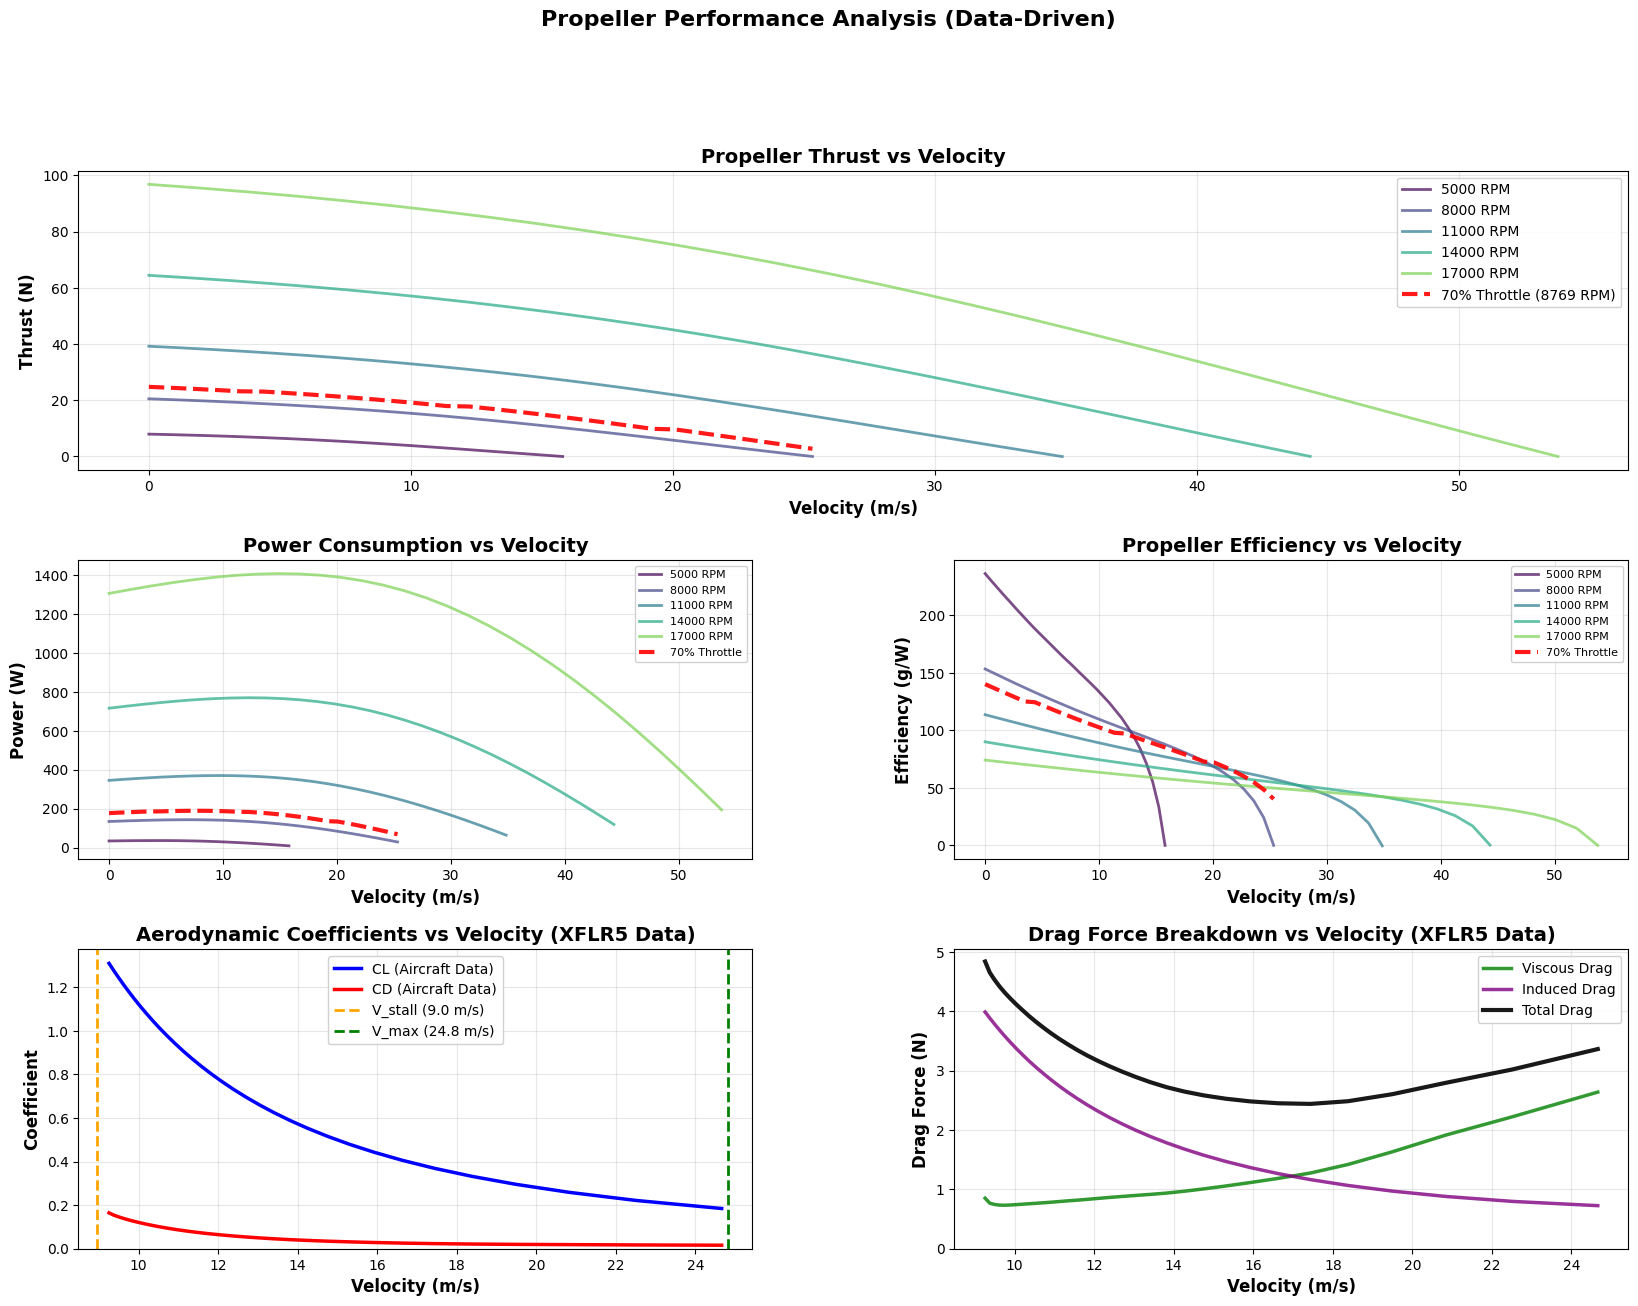

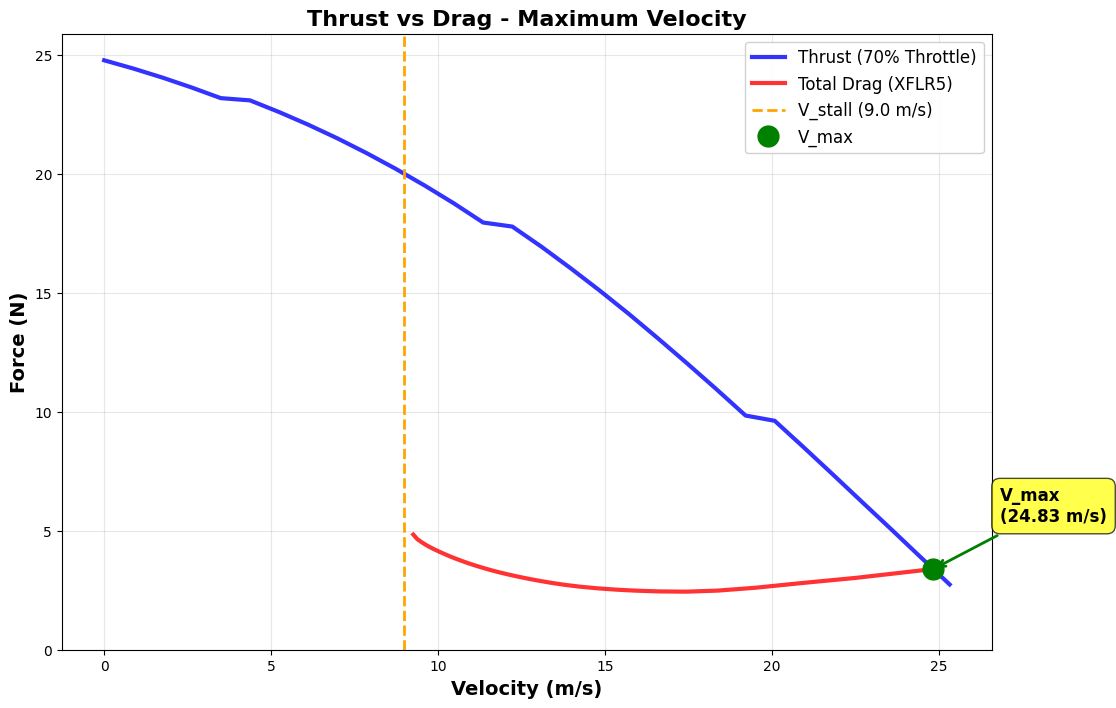

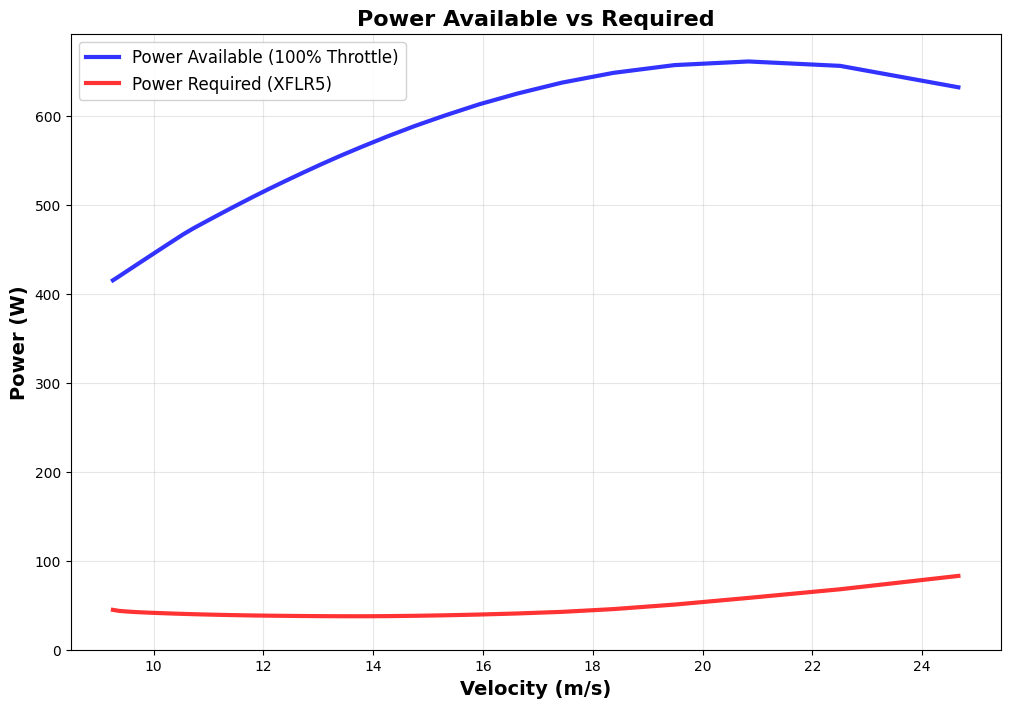

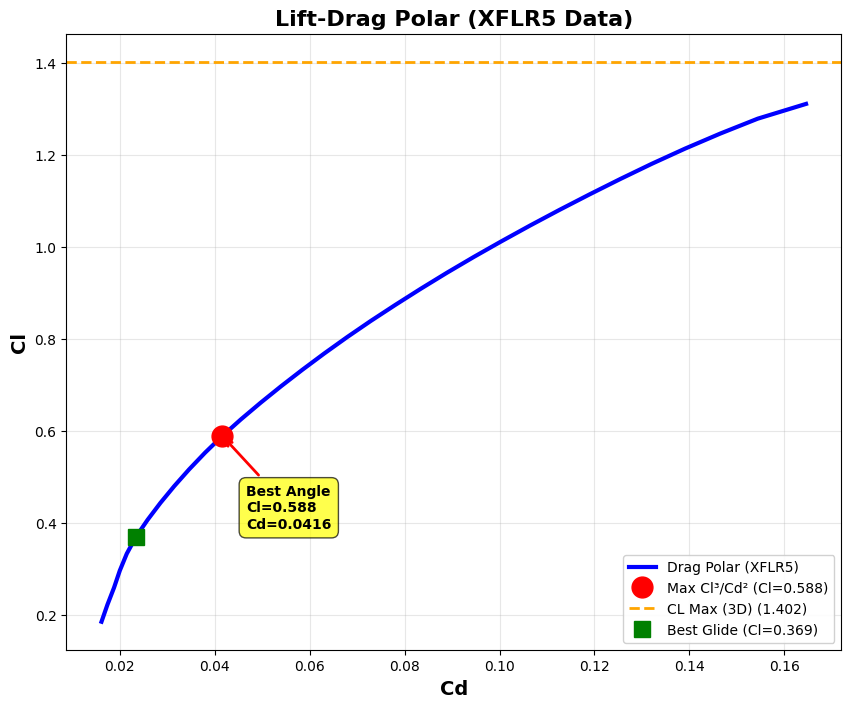

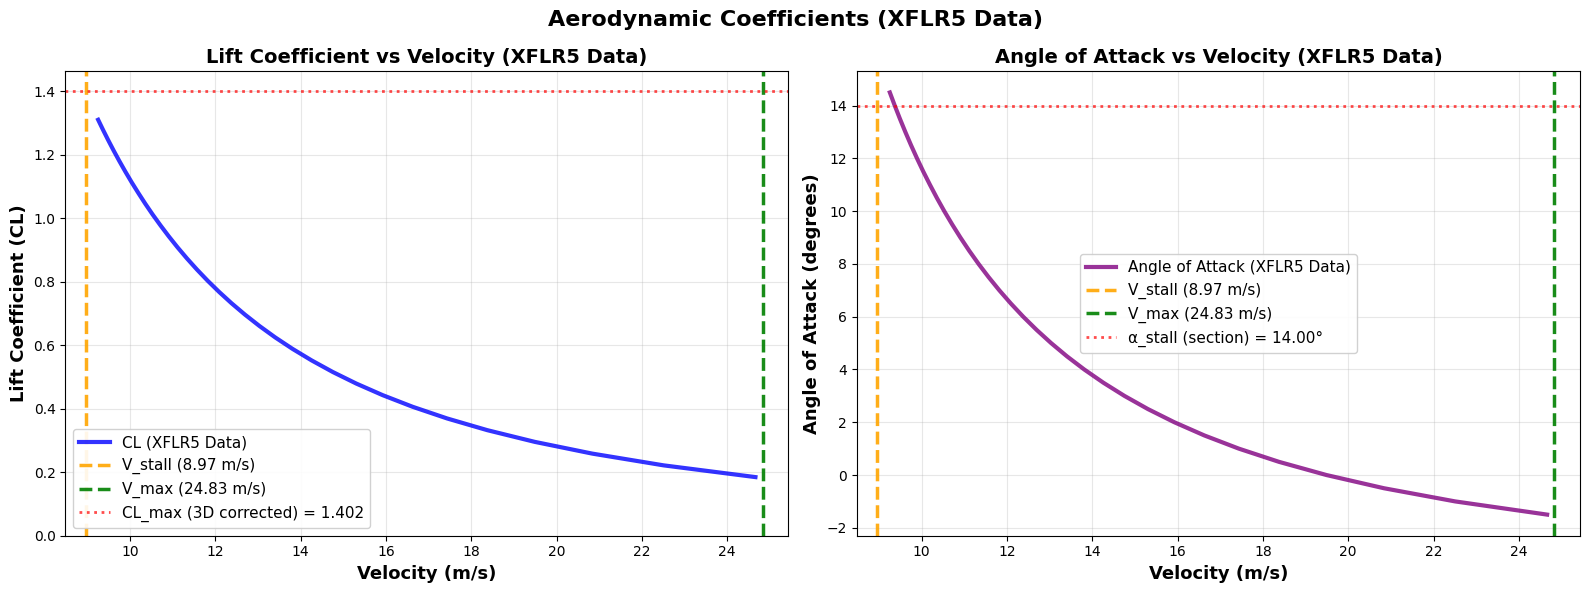

In [48]:
print("\n6. Creating plots...")
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# SUBPLOT 1: Thrust vs Velocity
ax1 = fig.add_subplot(gs[0, :])
colors = plt.cm.viridis(np.linspace(0, 0.8, len(SELECTED_RPMS)))
for rpm, color in zip(SELECTED_RPMS, colors):
    if rpm in prop_data:
        data = prop_data[rpm]
        velocities = [d['velocity_ms'] for d in data]
        thrusts = [d['thrust_N'] for d in data]
        ax1.plot(velocities, thrusts, '-', color=color, linewidth=2, 
                label=f'{rpm} RPM', alpha=0.7)
throttle_velocities = [d['velocity_ms'] for d in throttle_data]
throttle_thrusts = [d['thrust_N'] for d in throttle_data]
ax1.plot(throttle_velocities, throttle_thrusts, '--', color='red', linewidth=3,
        label=f'{THROTTLE_PERCENT}% Throttle ({throttle_rpm} RPM)', alpha=0.9)
ax1.set_xlabel('Velocity (m/s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Thrust (N)', fontsize=12, fontweight='bold')
ax1.set_title('Propeller Thrust vs Velocity', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', framealpha=0.9)

# SUBPLOT 2: Power vs Velocity
ax2 = fig.add_subplot(gs[1, 0])
for rpm, color in zip(SELECTED_RPMS, colors):
    if rpm in prop_data:
        data = prop_data[rpm]
        velocities = [d['velocity_ms'] for d in data]
        powers = [d['power_W'] for d in data]
        ax2.plot(velocities, powers, '-', color=color, linewidth=2, 
                label=f'{rpm} RPM', alpha=0.7)
throttle_powers = [d['power_W'] for d in throttle_data]
ax2.plot(throttle_velocities, throttle_powers, '--', color='red', linewidth=3,
        label=f'{THROTTLE_PERCENT}% Throttle', alpha=0.9)
ax2.set_xlabel('Velocity (m/s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Power (W)', fontsize=12, fontweight='bold')
ax2.set_title('Power Consumption vs Velocity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', framealpha=0.9, fontsize=8)

# SUBPLOT 3: Efficiency
ax3 = fig.add_subplot(gs[1, 1])
for rpm, color in zip(SELECTED_RPMS, colors):
    if rpm in prop_data:
        data = prop_data[rpm]
        velocities = [d['velocity_ms'] for d in data]
        efficiencies = [d['thrust_N'] / d['power_W'] * 1000 if d['power_W'] > 0 else 0 
                       for d in data]
        ax3.plot(velocities, efficiencies, '-', color=color, linewidth=2, 
                label=f'{rpm} RPM', alpha=0.7)
throttle_efficiencies = [d['thrust_N'] / d['power_W'] * 1000 if d['power_W'] > 0 else 0 
                        for d in throttle_data]
ax3.plot(throttle_velocities, throttle_efficiencies, '--', color='red', linewidth=3,
        label=f'{THROTTLE_PERCENT}% Throttle', alpha=0.9)
ax3.set_xlabel('Velocity (m/s)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Efficiency (g/W)', fontsize=12, fontweight='bold')
ax3.set_title('Propeller Efficiency vs Velocity', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', framealpha=0.9, fontsize=8)

# SUBPLOT 4: Coefficients (from aircraft data)
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(aircraft_data[v_col], aircraft_data[cl_col], '-', color='blue', 
         linewidth=2.5, label='CL (Aircraft Data)')
ax4.plot(aircraft_data[v_col], aircraft_data[cd_col], '-', color='red', 
         linewidth=2.5, label='CD (Aircraft Data)')
ax4.axvline(V_STALL, color='orange', linestyle='--', linewidth=2, 
           label=f'V_stall ({V_STALL:.1f} m/s)')
ax4.axvline(V_MAX, color='green', linestyle='--', linewidth=2, 
           label=f'V_max ({V_MAX:.1f} m/s)')
ax4.set_xlabel('Velocity (m/s)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Coefficient', fontsize=12, fontweight='bold')
ax4.set_title('Aerodynamic Coefficients vs Velocity (XFLR5 Data)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', framealpha=0.9)
ax4.set_ylim(bottom=0)

# SUBPLOT 5: Drag Breakdown (from aircraft data)
ax5 = fig.add_subplot(gs[2, 1])
# Try to plot drag breakdown if we have the data
if hasattr(aircraft_data, '_cd_viscous_col') and aircraft_data._cd_viscous_col and \
   hasattr(aircraft_data, '_cd_induced_col') and aircraft_data._cd_induced_col:
    
    drag_viscous = 0.5 * RHO * aircraft_data[v_col]**2 * S * aircraft_data[aircraft_data._cd_viscous_col]
    drag_induced = 0.5 * RHO * aircraft_data[v_col]**2 * S * aircraft_data[aircraft_data._cd_induced_col]
    drag_total = 0.5 * RHO * aircraft_data[v_col]**2 * S * aircraft_data[cd_col]
    
    ax5.plot(aircraft_data[v_col], drag_viscous, '-', color='green', 
            linewidth=2.5, label='Viscous Drag', alpha=0.8)
    ax5.plot(aircraft_data[v_col], drag_induced, '-', color='purple', 
            linewidth=2.5, label='Induced Drag', alpha=0.8)
    ax5.plot(aircraft_data[v_col], drag_total, '-', color='black', 
            linewidth=3, label='Total Drag', alpha=0.9)
    
    ax5.set_title('Drag Force Breakdown vs Velocity (XFLR5 Data)', fontsize=14, fontweight='bold')
else:
    # Just plot total drag
    drag_total = 0.5 * RHO * aircraft_data[v_col]**2 * S * aircraft_data[cd_col]
    ax5.plot(aircraft_data[v_col], drag_total, '-', color='black', 
            linewidth=3, label='Total Drag', alpha=0.9)
    ax5.set_title('Total Drag Force vs Velocity', fontsize=14, fontweight='bold')
ax5.set_xlabel('Velocity (m/s)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Drag Force (N)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best', framealpha=0.9)
ax5.set_ylim(bottom=0)
plt.suptitle('Propeller Performance Analysis (Data-Driven)', fontsize=16, fontweight='bold', y=0.995)

# FIGURE 2: Thrust vs Drag
fig2, ax_thrust_drag = plt.subplots(figsize=(12, 8))
ax_thrust_drag.plot(throttle_velocities, throttle_thrusts, '-', color='blue', 
                    linewidth=3, label=f'Thrust ({THROTTLE_PERCENT}% Throttle)', alpha=0.8)
drag_total_curve = 0.5 * RHO * aircraft_data[v_col]**2 * S * aircraft_data[cd_col]
ax_thrust_drag.plot(aircraft_data[v_col], drag_total_curve, '-', color='red', 
                    linewidth=3, label='Total Drag (XFLR5)', alpha=0.8)
ax_thrust_drag.axvline(V_STALL, color='orange', linestyle='--', linewidth=2, 
                      label=f'V_stall ({V_STALL:.1f} m/s)')
thrust_at_vmax = interpolate_thrust(throttle_data, V_MAX)
ax_thrust_drag.plot(V_MAX, thrust_at_vmax, 'o', color='green', markersize=15, 
                   label='V_max', zorder=5)
ax_thrust_drag.annotate(f'V_max\n({V_MAX:.2f} m/s)', 
                       xy=(V_MAX, thrust_at_vmax), 
                       xytext=(V_MAX + 2, thrust_at_vmax + 2),
                       fontsize=12, fontweight='bold',
                       arrowprops=dict(arrowstyle='->', lw=2, color='green'),
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
ax_thrust_drag.set_xlabel('Velocity (m/s)', fontsize=14, fontweight='bold')
ax_thrust_drag.set_ylabel('Force (N)', fontsize=14, fontweight='bold')
ax_thrust_drag.set_title('Thrust vs Drag - Maximum Velocity', fontsize=16, fontweight='bold')
ax_thrust_drag.grid(True, alpha=0.3)
ax_thrust_drag.legend(loc='best', framealpha=0.9, fontsize=12)
ax_thrust_drag.set_ylim(bottom=0)

# FIGURE 3: Power Available vs Required
fig3, ax_power = plt.subplots(figsize=(12, 8))
v_power_range = aircraft_data[v_col].values
P_A = [power_available(v, throttle_data_100) for v in v_power_range]
P_R = [power_required_data(v, interp_funcs) for v in v_power_range]
ax_power.plot(v_power_range, P_A, '-', color='blue', linewidth=3, 
              label='Power Available (100% Throttle)', alpha=0.8)
ax_power.plot(v_power_range, P_R, '-', color='red', linewidth=3, 
              label='Power Required (XFLR5)', alpha=0.8)
ax_power.set_xlabel('Velocity (m/s)', fontsize=14, fontweight='bold')
ax_power.set_ylabel('Power (W)', fontsize=14, fontweight='bold')
ax_power.set_title('Power Available vs Required', fontsize=16, fontweight='bold')
ax_power.grid(True, alpha=0.3)
ax_power.legend(loc='best', framealpha=0.9, fontsize=12)
ax_power.set_ylim(bottom=0)

# FIGURE 4: Drag Polar (from aircraft data)
fig4, ax_polar = plt.subplots(figsize=(10, 8))
ax_polar.plot(aircraft_data[cd_col], aircraft_data[cl_col], '-', color='blue', 
             linewidth=3, label='Drag Polar (XFLR5)')
# Mark max Cl^3/Cd^2 point
ax_polar.plot(Cd_max_performance, Cl_max_performance, 'o', color='red', markersize=15, 
             label=f'Max Cl³/Cd² (Cl={Cl_max_performance:.3f})', zorder=5)
ax_polar.annotate(f'Best Angle\nCl={Cl_max_performance:.3f}\nCd={Cd_max_performance:.4f}', 
                 xy=(Cd_max_performance, Cl_max_performance), 
                 xytext=(Cd_max_performance + 0.005, Cl_max_performance - 0.2),
                 fontsize=10, fontweight='bold',
                 arrowprops=dict(arrowstyle='->', lw=2, color='red'),
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
ax_polar.axhline(stall_data['CL_max_3d'], color='orange', linestyle='--', linewidth=2, 
                label=f"CL Max (3D) ({stall_data['CL_max_3d']:.3f})")

# Mark glide point
ax_polar.plot(Cd_glide, Cl_glide, 's', color='green', markersize=12, 
             label=f'Best Glide (Cl={Cl_glide:.3f})', zorder=5)
ax_polar.set_xlabel('Cd', fontsize=14, fontweight='bold')
ax_polar.set_ylabel('Cl', fontsize=14, fontweight='bold')
ax_polar.set_title('Lift-Drag Polar (XFLR5 Data)', fontsize=16, fontweight='bold')
ax_polar.grid(True, alpha=0.3)
ax_polar.legend(loc='best', framealpha=0.9)

# FIGURE 5: Lift Coefficient and Angle of Attack vs Velocity
fig5, (ax_cl, ax_aoa) = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: CL vs Velocity
ax_cl.plot(aircraft_data[v_col], aircraft_data[cl_col], '-', color='blue', 
           linewidth=3, label='CL (XFLR5 Data)', alpha=0.8)
ax_cl.axvline(V_STALL, color='orange', linestyle='--', linewidth=2.5, 
              label=f'V_stall ({V_STALL:.2f} m/s)', alpha=0.9)
ax_cl.axvline(V_MAX, color='green', linestyle='--', linewidth=2.5, 
              label=f'V_max ({V_MAX:.2f} m/s)', alpha=0.9)
ax_cl.axhline(stall_data['CL_max_3d'], color='red', linestyle=':', linewidth=2, 
              label=f'CL_max (3D corrected) = {stall_data["CL_max_3d"]:.3f}', alpha=0.7)
ax_cl.set_xlabel('Velocity (m/s)', fontsize=13, fontweight='bold')
ax_cl.set_ylabel('Lift Coefficient (CL)', fontsize=13, fontweight='bold')
ax_cl.set_title('Lift Coefficient vs Velocity (XFLR5 Data)', fontsize=14, fontweight='bold')
ax_cl.grid(True, alpha=0.3)
ax_cl.legend(loc='best', framealpha=0.9, fontsize=11)
ax_cl.set_ylim(bottom=0)

# Right subplot: Angle of Attack vs Velocity
if aircraft_data._alpha_col:
    ax_aoa.plot(aircraft_data[v_col], aircraft_data[aircraft_data._alpha_col], '-', color='purple', 
               linewidth=3, label='Angle of Attack (XFLR5 Data)', alpha=0.8)
    ax_aoa.axvline(V_STALL, color='orange', linestyle='--', linewidth=2.5, 
                   label=f'V_stall ({V_STALL:.2f} m/s)', alpha=0.9)
    ax_aoa.axvline(V_MAX, color='green', linestyle='--', linewidth=2.5, 
                   label=f'V_max ({V_MAX:.2f} m/s)', alpha=0.9)
    ax_aoa.axhline(stall_data['alpha_stall_section'], color='red', linestyle=':', linewidth=2, 
                   label=f'α_stall (section) = {stall_data["alpha_stall_section"]:.2f}°', alpha=0.7)
    ax_aoa.set_xlabel('Velocity (m/s)', fontsize=13, fontweight='bold')
    ax_aoa.set_ylabel('Angle of Attack (degrees)', fontsize=13, fontweight='bold')
    ax_aoa.set_title('Angle of Attack vs Velocity (XFLR5 Data)', fontsize=14, fontweight='bold')
    ax_aoa.grid(True, alpha=0.3)
    ax_aoa.legend(loc='best', framealpha=0.9, fontsize=11)
else:
    ax_aoa.text(0.5, 0.5, 'Angle of Attack data not available', 
               ha='center', va='center', fontsize=12, transform=ax_aoa.transAxes)
    ax_aoa.set_xlabel('Velocity (m/s)', fontsize=13, fontweight='bold')
    ax_aoa.set_ylabel('Angle of Attack (degrees)', fontsize=13, fontweight='bold')

plt.suptitle('Aerodynamic Coefficients (XFLR5 Data)', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save individual plots
fig_list = [
    (ax1, "1_thrust_vs_velocity"),
    (ax2, "2_power_vs_velocity"),
    (ax3, "3_efficiency_vs_velocity"),
    (ax4, "4_coefficients_vs_velocity"),
    (ax5, "5_drag_breakdown_vs_velocity")
]
for ax, name in fig_list:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(SCRIPT_DIR / f"{name}.png", bbox_inches=extent.expanded(1.3, 1.3), dpi=300)

============================================================================
PRINT SUMMARY
============================================================================

In [49]:
print("\n" + "="*80)
print("CLIMB PERFORMANCE SUMMARY (100% Throttle)")
print("="*80)
print(f"\n1. Maximum Rate of Climb (Max P_A - P_R):")
print(f"   Velocity:        {v_Pa_Pr_max:.2f} m/s")
print(f"   RC:              {RC_Pa_Pr_max:.2f} m/s ({RC_Pa_Pr_max * 60:.1f} m/min)")
print(f"   Cl:              {Cl_Pa_Pr:.3f}")
print(f"   AoA:             {AoA_Pa_Pr:.2f}°")
'''
print(f"\n2. Climb at 1.2 × V_stall:")
print(f"   Velocity:        {V_1_2_stall:.2f} m/s")
print(f"   RC:              {RC_1_2_stall:.2f} m/s ({RC_1_2_stall * 60:.1f} m/min)")
print(f"   Cl:              {Cl_1_2_stall:.3f}")
print(f"   AoA:             {AoA_1_2_stall:.2f}°")
'''
print(f"\n2. Best Angle of Climb (Max Cl³/Cd² from XFLR5 data):")
print(f"   Velocity:        {V_max_performance:.2f} m/s")
print(f"   RC:              {RC_max_performance:.2f} m/s ({RC_max_performance * 60:.1f} m/min)")
print(f"   Cl:              {Cl_max_performance:.3f}")
print(f"   Cd:              {Cd_max_performance:.4f}")
print(f"   AoA:             {AoA_max_performance:.2f}°")
print(f"   Cl³/Cd²:         {max_performance['Cl3_Cd2']:.2f}")
print(f"   Time to circuit altitude ({CLIMB_ALT} m): {calculate_climb_time(RC_max_performance, CLIMB_ALT):.2f} s")
print(f"\n" + "="*80)

print("GLIDE PERFORMANCE SUMMARY (from XFLR5 data)")
print("="*80)
print(f"   Velocity:        {V_glide:.2f} m/s")
print(f"   RD (descent):    {RD_glide:.2f} m/s ({RD_glide * 60:.1f} m/min)")
print(f"   Cl:              {Cl_glide:.3f}")
print(f"   Cd:              {Cd_glide:.4f}")
print(f"   AoA:             {AoA_glide:.2f}°")
print(f"   Glide angle:     {np.rad2deg(gamma_glide):.2f}°")
print(f"   L/D ratio:       {Cl_glide/Cd_glide:.2f}")
print(f"\n" + "="*80)
print("GENERAL PERFORMANCE SUMMARY")
print("="*80)
# ============================================================================
# PRINT PROPELLER SUMMARY DATA
# ============================================================================
print("\n" + "="*70)
print("PROPELLER PERFORMANCE SUMMARY")
print("="*70)
print(f"{'RPM':<15} {'Max Thrust (N)':<18} {'@ Velocity (m/s)':<20} {'Static Thrust (N)'}")
print("-"*70)
for rpm in sorted(SELECTED_RPMS + [throttle_rpm]):
    if rpm in prop_data or rpm == throttle_rpm:
        data = prop_data.get(rpm, interpolate_rpm_data(prop_data, rpm))
        
        max_thrust = max([d['thrust_N'] for d in data])
        max_thrust_point = [d for d in data if d['thrust_N'] == max_thrust][0]
        static_thrust = data[0]['thrust_N']
        
        label = f"{rpm}"
        if rpm == throttle_rpm:
            label += f" *{THROTTLE_PERCENT}%*"
        
        print(f"{label:<15} {max_thrust:<18.2f} {max_thrust_point['velocity_ms']:<20.2f} {static_thrust:.2f}")
print("="*70)
print("\n" + "="*70)
print("AERODYNAMIC PERFORMANCE SUMMARY (from XFLR5 data)")
print("="*70)
print(f"Stall Speed (V_stall):          {V_STALL:.2f} m/s")
print(f"Maximum Cruise Speed (V_max):   {V_MAX:.2f} m/s")
print(f"QAPOT Cruise Speed (V_cruise):  {V_CRUISE:.2f} m/s")
print(f"\nDrag at V_max:                  {drag_total_force_data(V_MAX, interp_funcs):.2f} N")
print(f"Thrust at V_max:                {thrust_at_vmax:.2f} N")
print(f"CD at V_max:                    {CD_function_data(V_MAX, interp_funcs):.4f}")
print(f"CL at V_max:                    {CL_function_data(V_MAX, interp_funcs):.4f}")
print(f"AoA at V_max:                   {get_alpha_data(V_MAX, interp_funcs):.2f}°")
print(f"\nDrag at V_cruise:               {drag_total_force_data(V_CRUISE, interp_funcs):.2f} N")
print(f"CD at V_cruise:                 {CD_function_data(V_CRUISE, interp_funcs):.4f}")
print(f"CL at V_cruise:                 {CL_function_data(V_CRUISE, interp_funcs):.4f}")
print(f"AoA at V_cruise:                {get_alpha_data(V_CRUISE, interp_funcs):.2f}°")
print("="*70)
# ============================================================================
# Save figures
output_file1 = SCRIPT_DIR / "propeller_analysis.png"
output_file2 = SCRIPT_DIR / "thrust_vs_drag_vmax.png"
output_file3 = SCRIPT_DIR / "power_available_vs_required.png"
output_file4 = SCRIPT_DIR / "drag_polar.png"
output_file5 = SCRIPT_DIR / "cl_aoa_vs_velocity.png"
fig.savefig(output_file1, dpi=300, bbox_inches='tight')
fig2.savefig(output_file2, dpi=300, bbox_inches='tight')
fig3.savefig(output_file3, dpi=300, bbox_inches='tight')
fig4.savefig(output_file4, dpi=300, bbox_inches='tight')
fig5.savefig(output_file5, dpi=300, bbox_inches='tight')
print(f"\nFigures saved as:")
print(f"  - {output_file1}")
print(f"  - {output_file2}")
print(f"  - {output_file3}")
print(f"  - {output_file4}")
print(f"  - {output_file5}")
print(f"  - Individual subplots saved as: 1_thrust_vs_velocity.png through 5_drag_breakdown_vs_velocity.png")
plt.show()


CLIMB PERFORMANCE SUMMARY (100% Throttle)

1. Maximum Rate of Climb (Max P_A - P_R):
   Velocity:        19.66 m/s
   RC:              15.69 m/s (941.2 m/min)
   Cl:              0.291
   AoA:             -0.06°

2. Best Angle of Climb (Max Cl³/Cd² from XFLR5 data):
   Velocity:        13.81 m/s
   RC:              13.66 m/s (819.9 m/min)
   Cl:              0.588
   Cd:              0.0416
   AoA:             4.00°
   Cl³/Cd²:         117.74
   Time to circuit altitude (61 m): 4.46 s

GLIDE PERFORMANCE SUMMARY (from XFLR5 data)
   Velocity:        17.44 m/s
   RD (descent):    1.10 m/s (66.1 m/min)
   Cl:              0.369
   Cd:              0.0234
   AoA:             1.00°
   Glide angle:     3.62°
   L/D ratio:       15.79

GENERAL PERFORMANCE SUMMARY

PROPELLER PERFORMANCE SUMMARY
RPM             Max Thrust (N)     @ Velocity (m/s)     Static Thrust (N)
----------------------------------------------------------------------
5000            7.95               0.00                 

============================================================================
SAVE DATA FOR LATER USE
============================================================================

In [47]:
# Create a DataFrame for export - Propeller data
export_data = []
for rpm in sorted(SELECTED_RPMS + [throttle_rpm]):
    if rpm in prop_data or rpm == throttle_rpm:
        data = prop_data.get(rpm, interpolate_rpm_data(prop_data, rpm))
        for point in data:
            export_data.append({
                'RPM': rpm,
                'Throttle_%': THROTTLE_PERCENT if rpm == throttle_rpm else None,
                'Velocity_ms': point['velocity_ms'],
                'Thrust_N': point['thrust_N'],
                'Power_W': point['power_W'],
                'Efficiency_gW': point['thrust_N'] / point['power_W'] * 1000 if point['power_W'] > 0 else 0
            })
df_prop = pd.DataFrame(export_data)
csv_file_prop = SCRIPT_DIR / "propeller_data.csv"
df_prop.to_csv(csv_file_prop, index=False)
print(f"\nPropeller data exported to: {csv_file_prop}")
# Export aircraft performance summary
summary_data = {
    'Parameter': [
        'Stall Speed (m/s)',
        'Max Speed (m/s)',
        'Cruise Speed (m/s)',
        'Max RC (m/s)',
        'Max RC (m/min)',
        'Best Climb Velocity (m/s)',
        'Best Climb RC (m/s)',
        'Best Climb AoA (deg)',
        'Best Glide Velocity (m/s)',
        'Best Glide L/D',
        'Best Glide AoA (deg)',
        'Time to Circuit Alt (s)',
        'CL_max_3d (airfoil)',
        'Alpha_stall_body (deg)'
    ],
    'Value': [
        V_STALL,
        V_MAX,
        V_CRUISE,
        RC_Pa_Pr_max,
        RC_Pa_Pr_max * 60,
        V_max_performance,
        RC_max_performance,
        AoA_max_performance,
        V_glide,
        Cl_glide / Cd_glide,
        AoA_glide,
        calculate_climb_time(RC_max_performance, CLIMB_ALT),
        stall_data['CL_max_3d'],
        stall_data['alpha_stall_body']
    ]
}
df_summary = pd.DataFrame(summary_data)
csv_file_summary = SCRIPT_DIR / "aircraft_performance_summary.csv"
df_summary.to_csv(csv_file_summary, index=False)
print(f"Aircraft performance summary exported to: {csv_file_summary}")
# Store in variables for later use in notebook
PROP_DATA = prop_data
THROTTLE_DATA = throttle_data
THROTTLE_RPM = throttle_rpm
V_MAX_CALCULATED = V_MAX
AIRCRAFT_DATA = aircraft_data
AIRFOIL_DATA = airfoil_data
STALL_DATA = stall_data
INTERP_FUNCS = interp_funcs
print("\n" + "="*70)
print("DATA-DRIVEN ANALYSIS COMPLETE")
print("="*70)
print("Airfoil data from: N10CLalpha.txt and N10CdAlpha.txt")
print("Aircraft performance from: OML1T2394kg.csv")
print("Propeller data from: PER3_10x6E.dat")
print("="*70)


Propeller data exported to: c:\Users\liuja\Trial1OfVspQAPOT\Aero-Basic-Performance\propeller_data.csv
Aircraft performance summary exported to: c:\Users\liuja\Trial1OfVspQAPOT\Aero-Basic-Performance\aircraft_performance_summary.csv

DATA-DRIVEN ANALYSIS COMPLETE
Airfoil data from: N10CLalpha.txt and N10CdAlpha.txt
Aircraft performance from: OML1T2394kg.csv
Propeller data from: PER3_10x6E.dat
